# Twitter Sentiment Analysis Pilpres 2019

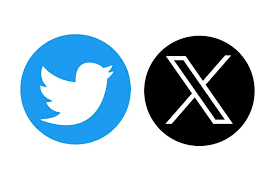
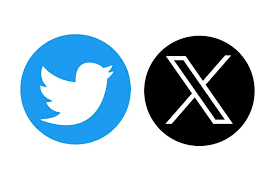

## Pernyataan Masalah:

Platform media sosial seperti *Twitter* telah menjadi sumber informasi dan opini publik. Menganalisis sentimen tweet dapat memberikan 
wawasan yang berharga tentang opini dan emosi orang terhadap berbagai topik, merek, atau peristiwa. Analisis sentimen Twitter melibatkan pengklasifikasian tweet secara otomatis ke dalam kategori sentimen **positif**, **negatif**, atau kategori sentimen **netral**. 

## Tujuan:

Tujuan dari proyek ini adalah untuk mengembangkan model analisis sentimen menggunakan pembelajaran mesin untuk mengklasifikasikan tweet berdasarkan sentimennya. Model ini akan dilatih pada sebuah dataset tweet yang telah diberi label dan akan dapat memprediksi sentimen tweet baru.

## Informasi Dataset:
Dataset yang digunakan adalah kumpulan data sentiment yang berasal dari pengguna twitter saat pelaksanaan PILPRES 2019 lalu. Terdiri dari `1815` data tweet yang memuat tiga kategori sentiment, yaitu: **Positif**, **Netral** dan **Negatif**.

## Import Libraries:

In [1]:
!pip install transformers
!pip install demoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.8 MB/s eta 0:00:00


In [2]:
# General purpose Packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing:
import re, string
import demoji
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Naive Bayes:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# Keras
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# set seed for reproducibility
seed = 42

# set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout = True)
plt.rc("axes", labelweight = "bold", labelsize = "large", titleweight = "bold", titlepad = 10)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<ipython-input-2-47c6516ba71e>:51: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

## Custom Functions Definition:
Blok kode ini mendefinisikan sebuah fungsi Python bernama conf_matrix yang membuat sebuah heatmap dari confusion matrix menggunakan pustaka seaborn. Fungsi ini menerima label sebenarnya, label prediksi, dan judul untuk plot sebagai parameter masukan.


In [3]:
def conf_matrix(y, y_pred, title):
    fig, ax = plt.subplots(figsize = (5, 5))
    labels = ['Negative', 'Neutral', 'Positive']
    ax = sns.heatmap(confusion_matrix(y, y_pred), annot = True, cmap = "Blues", fmt = 'g', cbar = False, annot_kws = {"size":25})
    plt.title(title, fontsize = 20)
    ax.xaxis.set_ticklabels(labels, fontsize = 17) 
    ax.yaxis.set_ticklabels(labels, fontsize = 17)
    ax.set_ylabel('Test', fontsize = 20)
    ax.set_xlabel('Predicted', fontsize = 20)
    plt.show()

## Loading the Data:

In [4]:
df = pd.read_csv('/kaggle/input/pilpres-2019-tweet-dataset/tweet.csv')

In [5]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.head() # print 5 baris pertama

,sentimen,tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [6]:
df.info() # Menampilkan informasi DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  1815 non-null   object
 1   tweet     1815 non-null   object
dtypes: object(2)
memory usage: 28.5+ KB


In [7]:
df.drop_duplicates(subset = 'tweet',inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentimen  1815 non-null   object
 1   tweet     1815 non-null   object
dtypes: object(2)
memory usage: 28.5+ KB


In [9]:
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


sentimen    0
tweet       0
dtype: int64

In [10]:
print("\nLabel Sentimen Unik:")
print(df['sentimen'].unique())


Label Sentimen Unik:
['negatif' 'netral' 'positif']


## Tweets Deep Cleaning:
Berikut ini, akan melakukan beberapa pembersihan data pada teks mentah dari tweet. Kemudian mendefinisikan fungsi khusus untuk membersihkan teks tweet.

Kode di bawah ini mendefinisikan beberapa fungsi khusus untuk membersihkan tweet. 
- Fungsi strip_emoji() menggunakan pustaka demoji untuk menghapus emoji dari teks.
- Fungsi strip_all_entities() menghapus tanda baca, tautan, sebutan, dan karakter baris baru.
- Fungsi clean_hashtags() menghapus tagar dari akhir kalimat dan mempertahankan tagar di tengah kalimat.
- Fungsi filter_chars() menyaring karakter khusus seperti $ dan & yang ada di beberapa kata.
- Fungsi remove_mult_spaces() menghapus beberapa spasi dari teks.

In [11]:
## CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

# Clean emojis from text:
def strip_emoji(text):
    return demoji.replace(text, '') #remove emoji

# Remove punctuations, links, mentions and \r\n new line characters:
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol:
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

Blok kode ini membersihkan tweet di kolom tweet pada dataframe pandas df menggunakan fungsi kustom yang didefinisikan sebelumnya:
- (remove_mult_spaces()
- filter_chars()
- clean_hashtags()
- strip_all_entities()
- strip_emoji()).
  
Tweet yang telah dibersihkan kemudian disimpan dalam daftar baru texts_new.

In [12]:
texts_new = []
for t in df.tweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

Blok kode ini membuat kolom baru 'text_clean' pada dataframe dan mengisinya dengan teks tweet yang telah dibersihkan yang diperoleh dengan menerapkan berbagai fungsi pembersihan yang didefinisikan sebelumnya pada kolom 'tweet' pada dataframe.

In [13]:
df['text_clean'] = texts_new

Blok kode ini menunjukkan beberapa tweet pertama yang dibersihkan di kolom 'text_clean' pada Pandas DataFrame 'df'.

In [14]:
df['text_clean'].head()

0    kata indonesia tidak dihargai bangsa asing ber...
1    batuan langka tasbih jokowi hadiah dari habib ...
2    di era jokowi ekonomi indonesia semakin baik 0...
3    bagi sumatera selatan asian games berdampak pd...
4    negara kita ngutang buat bngun infrastruktur y...
Name: text_clean, dtype: object

In [15]:
df['text_clean'][1:8].values

array(['batuan langka tasbih jokowi hadiah dari habib luthfi seharga mercy',
       'di era jokowi ekonomi indonesia semakin baik 01indonesiamaju jokowilagi jokowimenangtotaldebat pictwittercomw2ythnxstp',
       'bagi sumatera selatan asian games berdampak pd ekonomi langsung diprediksi mencapai 185 triliun indonesia maju jokowi hebat',
       'negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat terus masyarakatnya ngeluh karena negara ngutang setiap negara itu pasti ngutang utang bisa dibayar kalo negara dapet penghasilan penghasilan negara itu ya dari pajak',
       'yg bisikin pak jokowi cm mikirin perputaran duit di golongan tertentu esports hanya sebagian kecil dr sekian besar penentu pertumbuhan perekonomian indonesia bukan hal fundamental betul yg dikatakan prabowo walau dgn bhs yg sederhana tp mrpkan aspek fundamental ekonomi',
       'masa tenang msih ngoceh ajattp jokowi harga mati',
       'uasdifitnahkejibalasditps kerjasa ekonomi bilateral multilatera

In [16]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [17]:
df['text_len'] = text_len

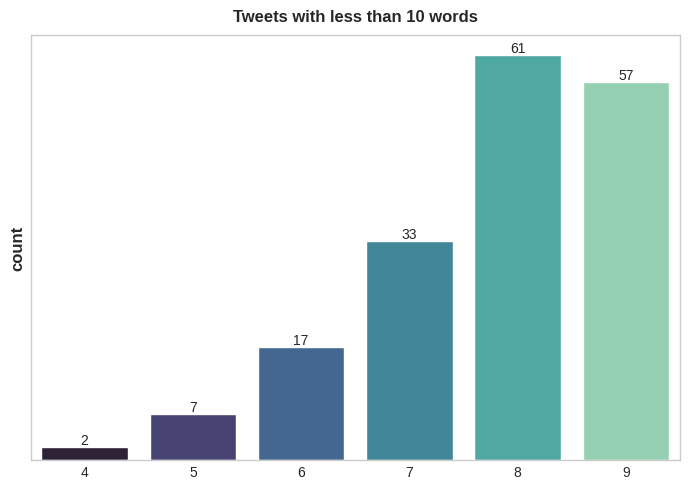

In [18]:
plt.figure(figsize = (7,5))
ax = sns.countplot(x = 'text_len', data = df[df['text_len']<10], palette = 'mako')
plt.title('Tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [19]:
print(f" DF Shape: {df.shape}")

 DF Shape: (1815, 4)


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentimen    1815 non-null   object
 1   tweet       1815 non-null   object
 2   text_clean  1815 non-null   object
 3   text_len    1815 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 56.8+ KB


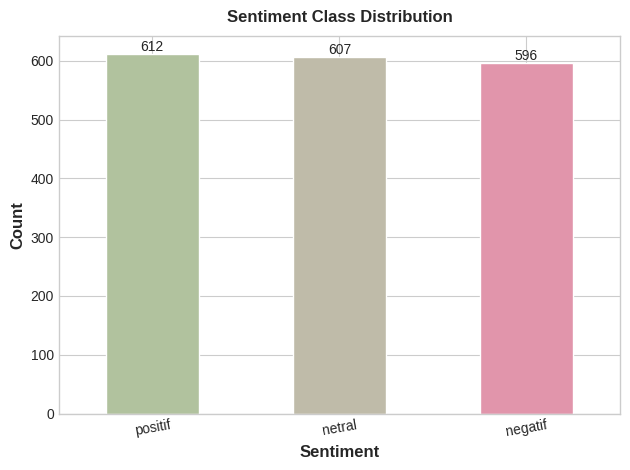

In [21]:
class_dist = df['sentimen'].value_counts()

ax = class_dist.plot(kind = 'bar', color = ['#B1C29E', '#BFBBA9', '#E195AB'])
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.xticks(rotation = 10)
plt.ylabel('Count')

# Add counts on top of the bars
for index, value in enumerate(class_dist):
    plt.text(index, value, str(value), ha = 'center', va = 'bottom')
plt.show();

In [22]:
sentiment_label2id_map = {'negatif': 0, 'netral': 1, 'positif': 2}
sentiment_id2label_map = {0: 'negatif', 1: 'netral', 2: 'positif'}

df['sentimen'] = df['sentimen'].map(sentiment_label2id_map)
df.head()

,sentimen,tweet,text_clean,text_len
0,0,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata indonesia tidak dihargai bangsa asing ber...,14
1,1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah dari habib ...,10
2,1,"Di era Jokowi, ekonomi Indonesia semakin baik....",di era jokowi ekonomi indonesia semakin baik 0...,11
3,2,"Bagi Sumatera Selatan, Asian Games berdampak p...",bagi sumatera selatan asian games berdampak pd...,17
4,0,Negara kita ngutang buat bngun infrastruktur y...,negara kita ngutang buat bngun infrastruktur y...,34


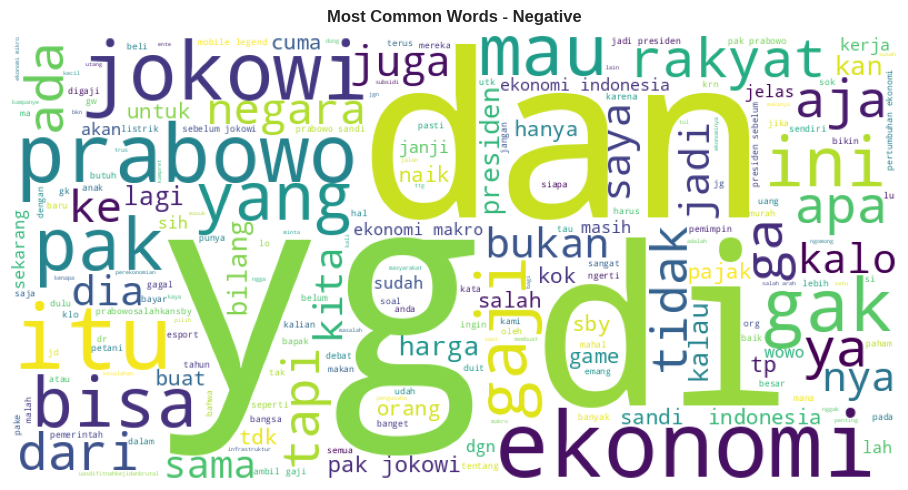

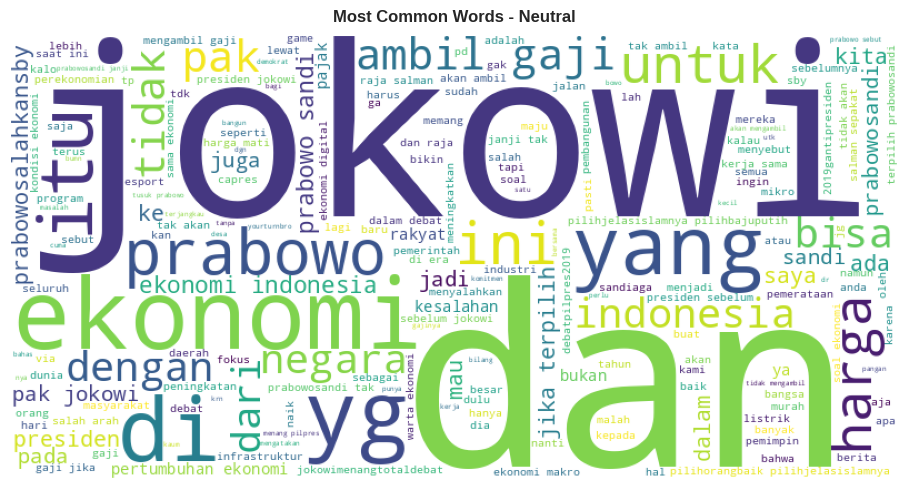

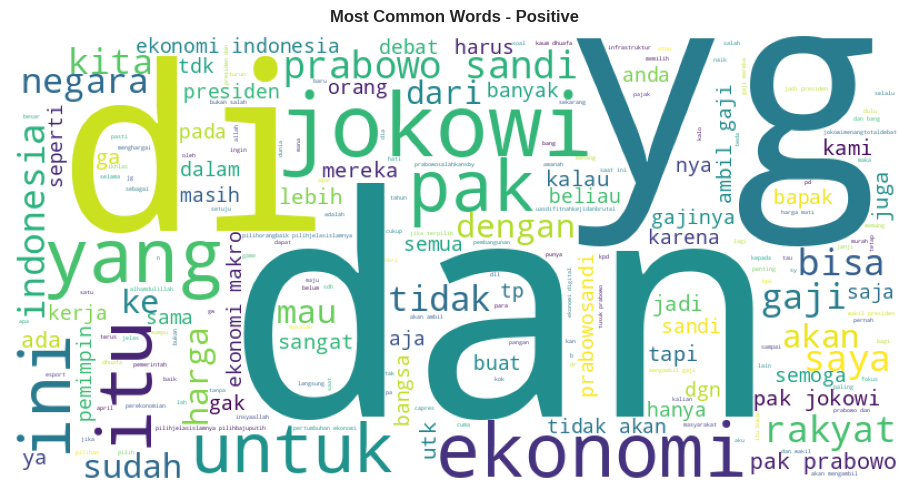

In [23]:
def generate_wordcloud(sentiment_value, title):
    text = ' '.join(df[df['sentimen'] == sentiment_value]['text_clean'])
    wordcloud = WordCloud(width = 800, height = 400,
                          background_color = 'white').generate(text)
    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud)
    plt.title(f'Most Common Words - {title}')
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment
generate_wordcloud(0, 'Negative')
generate_wordcloud(1, 'Neutral')
generate_wordcloud(2, 'Positive')

## Data Modeling:

### 1. Random Forest Model:

In [24]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features = 5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['text_clean'])

In [25]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['sentimen'], test_size = 0.2, random_state = 42)

In [26]:
# Train Random Forest model:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Model Evaluation:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Model Evaluation:
              precision    recall  f1-score   support

           0       0.57      0.60      0.59       115
           1       0.58      0.64      0.61       118
           2       0.57      0.48      0.52       130

    accuracy                           0.57       363
   macro avg       0.57      0.58      0.57       363
weighted avg       0.57      0.57      0.57       363

Accuracy: 0.5730027548209367


### LSTM Model:

In [28]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

In [29]:
# Tokenization and padding for LSTM
tokenizer = Tokenizer(num_words = 5000, oov_token = '<OOV>')
tokenizer.fit_on_texts(df['text_clean'])
X_sequences = tokenizer.texts_to_sequences(df['text_clean'])
X_padded = pad_sequences(X_sequences, maxlen = 100, padding = 'post')

In [30]:
# Split data
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_padded, df['sentimen'], test_size = 0.2, random_state = 42)

In [31]:
# Convert labels to categorical
from keras.utils import to_categorical
y_train_lstm = to_categorical(y_train_lstm)
y_test_lstm = to_categorical(y_test_lstm)

In [32]:
# Build LSTM model
lstm_model = Sequential([
    Embedding(input_dim = 5000, output_dim = 128, input_length = 100),
    LSTM(128, return_sequences = True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(3, activation = 'softmax')
])

lstm_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [33]:
# Train LSTM model:
lstm_model.fit(X_train_lstm, y_train_lstm, epochs = 5, batch_size = 32, validation_split = 0.2)

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.3182 - loss: 1.1035 - val_accuracy: 0.2955 - val_loss: 1.1010
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3293 - loss: 1.1007 - val_accuracy: 0.2955 - val_loss: 1.1015
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3429 - loss: 1.0983 - val_accuracy: 0.2955 - val_loss: 1.0997
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3282 - loss: 1.0994 - val_accuracy: 0.2955 - val_loss: 1.0993
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3314 - loss: 1.0993 - val_accuracy: 0.2955 - val_loss: 1.1031


In [34]:
# Predict and evaluate
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm_classes = y_pred_lstm.argmax(axis = 1)
y_test_lstm_classes = y_test_lstm.argmax(axis = 1)
print("LSTM Model Evaluation:")
print(classification_report(y_test_lstm_classes, y_pred_lstm_classes))
print("Accuracy:", accuracy_score(y_test_lstm_classes, y_pred_lstm_classes))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
LSTM Model Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.00      0.00      0.00       118
           2       0.36      1.00      0.53       130

    accuracy                           0.36       363
   macro avg       0.12      0.33      0.18       363
weighted avg       0.13      0.36      0.19       363

Accuracy: 0.3581267217630854


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Hyperparameter Tuning:

### Hyperparameter Tuning untuk Random Forest:

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
# Definisikan parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [37]:
# Inisialisasi model Random Forest
rf_model = RandomForestClassifier(random_state = seed)

In [38]:
# Inisialisasi GridSearchCV:
grid_search_rf = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                               cv = 3, n_jobs = -1, verbose = 2, scoring = 'accuracy')

In [39]:
# Fit model
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [40]:
# Hasil terbaik
print("Best Hyperparameters for Random Forest:")
print(grid_search_rf.best_params_)
print("Best Accuracy:", grid_search_rf.best_score_)

Best Hyperparameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.5840220385674931


## Training Data Deeper Cleaning:
Makukan pembersihan lebih lanjut dengan memeriksa versi tokenizer dari kalimat-kalimat tersebut.

In [41]:
# import the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [42]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length = 512, truncation = True)
    token_lens.append(len(tokens))
    
max_len = np.max(token_lens)

In [43]:
print(f"Max Tokenized Sentence Length: {max_len}")

Max Tokenized Sentence Length: 120


Memeriksa kalimat-kalimat panjang yang diberi token (dengan lebih dari 80 token):
Kode ini menghitung panjang token yang disandikan untuk setiap teks tweet di kolom 'text_clean' pada dataframe 'df'. Kode ini menggunakan tokenizer Hugging Face untuk men-tokenize teks menjadi token dengan panjang maksimum 512 dan memotong teks jika melebihi batas ini. Kode ini juga mencetak indeks dan teks tweet yang memiliki lebih dari 80 token.

In [44]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length = 512, truncation = True)
    token_lens.append(len(tokens))
    if len(tokens) > 80:
        print(f"Index: {i}, Text: {txt}")  

Index: 4, Text: negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat terus masyarakatnya ngeluh karena negara ngutang setiap negara itu pasti ngutang utang bisa dibayar kalo negara dapet penghasilan penghasilan negara itu ya dari pajak
Index: 5, Text: yg bisikin pak jokowi cm mikirin perputaran duit di golongan tertentu esports hanya sebagian kecil dr sekian besar penentu pertumbuhan perekonomian indonesia bukan hal fundamental betul yg dikatakan prabowo walau dgn bhs yg sederhana tp mrpkan aspek fundamental ekonomi
Index: 8, Text: iya bener aa kita mantap kan pilihan ke pemimpin yg bs memberi solusi bukan yg menyalahkan pemimpin sebelumnya dismash sm mas bowo percuma koalisi klau mengantam tmn koalisi yg plg penting pilih pemimpin yg rajin ibadah wajib bisa ngaji jumatan
Index: 11, Text: calon presiden jokowi menjelaskan program kartu pra kerja akan memberikan insentif dalam kurun waktu tertentu bukan berarti memberikan gaji secara cumacuma bagi masyarakat yang bel

In [45]:
df['token_lens'] = token_lens

Kode ini menampilkan 20 tweet dengan jumlah token (kata) terbanyak pada kolom teks yang telah dibersihkan. DataFrame df diurutkan dalam urutan menurun berdasarkan kolom token_lens yang berisi panjang (jumlah token) setiap tweet setelah diproses oleh tokenizer.

In [46]:
df = df.sort_values(by = 'token_lens', ascending = False)
df.head(20)

,sentimen,tweet,text_clean,text_len,token_lens
1394,0,Gaji kecil gadiambil tp tunjangan milyaran/bln...,gaji kecil gadiambil tp tunjangan milyaranbln ...,38,120
1426,0,Pakta integritas wo Pulangkan Nb Brizik jd Men...,pakta integritas wo pulangkan nb brizik jd men...,27,118
336,2,Bukan maksud sy sombong. Sy bisa menghidupi ke...,bukan maksud sy sombong sy bisa menghidupi kel...,43,116
895,1,Ekonom CSIS Fajar B Hirawan menjelaskan faktor...,ekonom csis fajar b hirawan menjelaskan faktor...,32,115
1686,2,#DebatTerakhirPilpres2019 Slh satu bukti Ref...,debatterakhirpilpres2019 slh satu bukti reform...,39,114
1697,1,"Capres nomor urut 02, @prabowo: Digital-digita...",capres nomor urut 02 digitaldigital itu bagus ...,31,113
658,0,"Buka mata, siapa yg mau beli saham indosat yg ...",buka mata siapa yg mau beli saham indosat yg r...,46,113
538,0,Lah kalian yg mulai kata nya klo gak milih jok...,lah kalian yg mulai kata nya klo gak milih jok...,49,112
877,2,Makasih ya Allah.. skenario MU begitu Agung. E...,makasih ya allah skenario mu begitu agung engk...,39,112
243,1,Tnya sj pd diri anda jg apa msh sehat jg g and...,tnya sj pd diri anda jg apa msh sehat jg g and...,53,111


In [47]:
df = df.iloc[12:]
df.head()

,sentimen,tweet,text_clean,text_len,token_lens
1253,0,Itulah yg tdk masuk logika cebong..prabowo san...,itulah yg tdk masuk logika cebongprabowo sandi...,40,110
1093,2,Itu bedanya pemimpin dan bukan pemimpin. Pemim...,itu bedanya pemimpin dan bukan pemimpin pemimp...,37,110
1073,2,Ayo k TPS dan Tusuk Prabowo Sandi 02. makin ki...,ayo k tps dan tusuk prabowo sandi 02 makin kin...,43,110
966,2,"Sebuah closing statement yg mantap, Prabowo Su...",sebuah closing statement yg mantap prabowo sub...,38,110
731,0,Wowo kesalahan arah ekonomi yang mengakibatkan...,wowo kesalahan arah ekonomi yang mengakibatkan...,33,110


In [48]:
df = df.sample(frac = 1).reset_index(drop = True)

In [49]:
df['sentimen'].value_counts()

sentimen
2    609
1    603
0    591
Name: count, dtype: int64